# Overview

A `quantify-core` experiment typically consists of a data-acquisition loop in
which one or more parameters are set and one or more parameters are measured.

The core of Quantify can be understood by understanding the following concepts:

- {ref}`Instruments and Parameters`
- {ref}`Measurement Control`
- {ref}`Settables and Gettables`
- {ref}`Data storage`
- {ref}`Analysis`

## Code snippets

```{seealso}
The complete source code of the examples on this page can be found in

{nb-download}`concepts.ipynb`
```

In [1]:
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from qcodes import Instrument, ManualParameter, Parameter, validators
from scipy.optimize import minimize_scalar

import quantify_core.data.handling as dh
from quantify_core.analysis import base_analysis as ba
from quantify_core.analysis import cosine_analysis as ca
from quantify_core.measurement import Gettable, MeasurementControl
from quantify_core.utilities.dataset_examples import mk_2d_dataset_v1
from quantify_core.utilities.examples_support import mk_cosine_instrument
from quantify_core.utilities.inspect_utils import display_source_code

dh.set_datadir(dh.default_datadir())
meas_ctrl = MeasurementControl("meas_ctrl")

Data will be saved in:
/home/rsoko/quantify-data


# Instruments and Parameters

## Parameter

A parameter represents a state variable of the system. Parameters:

- can be gettable and/or settable;
- contain metadata such as units and labels;
- are commonly implemented using the QCoDeS {class}`~qcodes.parameters.Parameter` class.

A parameter implemented using the QCoDeS {class}`~qcodes.parameters.Parameter` class
is a valid {class}`.Settable` and {class}`.Gettable` and as such can be used directly in
an experiment loop in the {class}`.MeasurementControl` (see subsequent sections).

## Instrument

An Instrument is a container for parameters that typically (but not necessarily)
corresponds to a physical piece of hardware.

Instruments provide the following functionality:

- Container for parameters.
- A standardized interface.
- Logging of parameters through the {meth}`~qcodes.instrument.Instrument.snapshot` method.

All instruments inherit from the QCoDeS {class}`~qcodes.instrument.Instrument` class.
They are displayed by default in the {class}`.InstrumentMonitor`

# Measurement Control

The {class}`.MeasurementControl` (meas_ctrl) is in charge of the data-acquisition loop
and is based on the notion that, in general, an experiment consists of the following
three steps:

1. Initialize (set) some parameter(s),
2. Measure (get) some parameter(s),
3. Store the data.

`quantify-core` provides two helper classes, {class}`.Settable` and {class}`.Gettable` to aid
in these steps, which are explored further in later sections of this article.

{class}`.MeasurementControl` provides the following functionality:

- standardization of experiments;
- standardization data storage;
- {ref}`live plotting of the experiment <plotmon-tutorial>`;
- {math}`n`-dimensional sweeps;
- data acquisition controlled iteratively or in batches;
- adaptive sweeps (measurement points are not predetermined at the beginning of an experiment).

## Basic example, a 1D iterative measurement loop

Running an experiment is simple!
Simply define what parameters to set, and get, and what points to loop over.

In the example below we want to set frequencies on a microwave source and acquire the
signal from the Qblox Pulsar readout module:

In [2]:
mw_source1 = Instrument("mw_source1")

# NB: for brevity only, this not the proper way of adding parameters to QCoDeS instruments
mw_source1.freq = ManualParameter(
    name="freq",
    label="Frequency",
    unit="Hz",
    vals=validators.Numbers(),
    initial_value=1.0,
)

pulsar_QRM = Instrument("pulsar_QRM")
# NB: for brevity only, this not the proper way of adding parameters to QCoDeS instruments
pulsar_QRM.signal = Parameter(
    name="sig_a", label="Signal", unit="V", get_cmd=lambda: mw_source1.freq() * 1e-8
)

In [3]:
meas_ctrl.settables(
    mw_source1.freq
)  # We want to set the frequency of a microwave source
meas_ctrl.setpoints(np.arange(5e9, 5.2e9, 100e3))  # Scan around 5.1 GHz
meas_ctrl.gettables(pulsar_QRM.signal)  # acquire the signal from the pulsar QRM
dset = meas_ctrl.run(name="Frequency sweep")  # run the experiment

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

The {class}`.MeasurementControl` can also be used to perform more advanced experiments
such as 2D scans, pulse-sequences where the hardware is in control of the acquisition
loop, or adaptive experiments in which it is not known what data points to acquire in
advance, they are determined dynamically during the experiment.
Take a look at some of the tutorial notebooks for more in-depth examples on
usage and application.

## Control Mode

Batched mode can be used to deal with constraints imposed by (hardware) resources or to reduce overhead.

In **iterative mode** , the measurement control steps through each setpoint one at a time,
processing them one by one.

In **batched mode** , the measurement control vectorizes the setpoints such that they are processed in batches.
The size of these batches is automatically calculated but usually dependent on resource
constraints; you may have a device that can hold 100 samples but you wish to sweep over 2000 points.

```{note}
The maximum batch size of the settable(s)/gettable(s) should be specified using the
`.batch_size` attribute. If not specified infinite size is assumed and all setpoint
are passed to the settable(s).
```

```{tip}
In *Batched* mode it is still possible to perform outer iterative sweeps with an inner
batched sweep.
This is performed automatically when batched settables (`.batched=True`) are mixed
with iterative settables (`.batched=False`). To correctly grid the points in this mode
use {meth}`.MeasurementControl.setpoints_grid`.
```

Control mode is detected automatically based on the `.batched` attribute of the
settable(s) and gettable(s); this is expanded upon in subsequent sections.

```{note}
All gettables must have the same value for the `.batched` attribute.
Only when all gettables have `.batched=True`, settables are allowed to have mixed
`.batched` attribute (e.g. `settable_A.batched=True`, `settable_B.batched=False`).
```

Depending on which control mode the {class}`.MeasurementControl` is running in,
the interfaces for Settables (their input interface) and Gettables
(their output interface) are slightly different.

It is also possible for batched gettables to return an array with a length less
than the length of the setpoints, and similarly for the input of the Settables.
This is often the case when working with resource-constrained devices, for
example, if you have *n* setpoints but your device can load only less than *n*
datapoints into memory. In this scenario, measurement control tracks how many
datapoints were actually processed, automatically adjusting the size of the next
batch.

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 time 
Batch size limit: 5



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

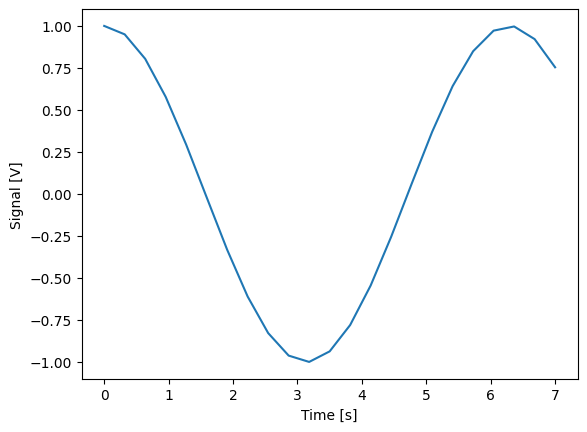

In [4]:
time = ManualParameter(
    name="time",
    label="Time",
    unit="s",
    vals=validators.Arrays(),  # accepts an array of values
)
signal = Parameter(
    name="sig_a", label="Signal", unit="V", get_cmd=lambda: np.cos(time())
)

time.batched = True
time.batch_size = 5
signal.batched = True
signal.batch_size = 10

meas_ctrl.settables(time)
meas_ctrl.gettables(signal)
meas_ctrl.setpoints(np.linspace(0, 7, 23))
dset = meas_ctrl.run("my experiment")
dset_grid = dh.to_gridded_dataset(dset)

dset_grid.y0.plot()

# Settables and Gettables

Experiments typically involve varying some parameters and reading others.
In `quantify-core` we encapsulate these concepts as the {class}`.Settable`
and {class}`.Gettable` respectively.
As their name implies, a Settable is a parameter you set values to,
and a Gettable is a parameter you get values from.

The interfaces for Settable and Gettable parameters are encapsulated in the
{class}`.Settable` and {class}`.Gettable` helper classes respectively.
We set values to Settables; these values populate an `X`-axis.
Similarly, we get values from Gettables which populate a `Y`-axis.
These classes define a set of mandatory and optional attributes the
{class}`.MeasurementControl` recognizes and will use as part of the experiment,
which are expanded up in the API reference.
For ease of use, we do not require users to inherit from a Gettable/Settable class,
and instead provide contracts in the form of JSON schemas to which these classes
must fit (see {class}`.Settable` and {class}`.Gettable` docs for these schemas).
In addition to using a library that fits these contracts
(such as the {class}`~qcodes.parameters.Parameter` family of classes).
we can define our own Settables and Gettables.

In [5]:
t = ManualParameter("time", label="Time", unit="s")


class WaveGettable:
    """An examples of a gettable."""

    def __init__(self):
        self.unit = "V"
        self.label = "Amplitude"
        self.name = "sine"

    def get(self):
        """Return the gettable value."""
        return np.sin(t() / np.pi)

    def prepare(self) -> None:
        """Optional methods to prepare can be left undefined."""
        print("Preparing the WaveGettable for acquisition.")

    def finish(self) -> None:
        """Optional methods to finish can be left undefined."""
        print("Finishing WaveGettable to wrap up the experiment.")


# verify compliance with the Gettable format
wave_gettable = WaveGettable()
Gettable(wave_gettable)

"Grouped" gettable(s) are also allowed.
Below we create a Gettable which returns two distinct quantities at once:

In [6]:
t = ManualParameter(
    "time",
    label="Time",
    unit="s",
    vals=validators.Numbers(),  # accepts a single number, e.g. a float or integer
)


class DualWave1D:
    """Example of a "dual" gettable."""

    def __init__(self):
        self.unit = ["V", "V"]
        self.label = ["Sine Amplitude", "Cosine Amplitude"]
        self.name = ["sin", "cos"]

    def get(self):
        """Return the value of the gettable."""
        return np.array([np.sin(t() / np.pi), np.cos(t() / np.pi)])

    # N.B. the optional prepare and finish methods are omitted in this Gettable.


# verify compliance with the Gettable format
wave_gettable = DualWave1D()
Gettable(wave_gettable)

(sec-batched-and-batch-size)=
## .batched and .batch_size

The {py:class}`.Gettable` and {py:class}`.Settable` objects can have a `bool` property
`.batched` (defaults to `False` if not present); and an `int` property `.batch_size`.

Setting the `.batched` property to `True` enables the *batched control code**
in the {class}`.MeasurementControl`. In this mode, if present,
the `.batch_size` attribute is used to determine the maximum size of a batch of
setpoints, that can be set.

```{admonition} Heterogeneous batch size and effective batch size
:class: dropdown, note

The minimum `.batch_size` among all settables and gettables will determine the
(maximum) size of a batch.
During execution of a measurement the size of a batch will be reduced if necessary
to comply to the setpoints grid and/or total number of setpoints.
```

## .prepare() and .finish()

Optionally the {meth}`!.prepare` and {meth}`!.finish` can be added.
These methods can be used to set up and teardown work.
For example, arming a piece of hardware with data and then closing a connection upon
completion.

The {meth}`!.finish` runs once at the end of an experiment.

For `settables`, {meth}`!.prepare` runs once **before the start of a measurement**.

For batched `gettables`, {meth}`!.prepare` runs **before the measurement of each batch**.
For iterative `gettables`, the {meth}`!.prepare` runs before each loop counting towards
soft-averages \[controlled by {meth}`!meas_ctrl.soft_avg()` which resets to `1`
at the end of each experiment\].

(data-storage)=
# Data storage

Along with the produced dataset, every {class}`~qcodes.parameters.Parameter`
attached to QCoDeS {class}`~qcodes.instrument.Instrument` in an experiment run through
the {class}`.MeasurementControl` of Quantify is stored in the [snapshot].

This is intended to aid with reproducibility, as settings from a past experiment can
easily be reloaded \[see {func}`~quantify_core.utilities.experiment_helpers.load_settings_onto_instrument`\].

## Data Directory
The top-level directory in the file system where output is saved to.
This directory can be controlled using the {meth}`~quantify_core.data.handling.get_datadir`
and {meth}`~quantify_core.data.handling.set_datadir` functions.
We recommend changing the default directory when starting the python kernel
(after importing {mod}`quantify_core`) and settling for a single common data directory
for all notebooks/experiments within your measurement setup/PC
(e.g., {code}`D:\\quantify-data`).

`quantify-core` provides utilities to find/search and extract data,
which expects all your experiment containers to be located within the same directory
(under the corresponding date subdirectory).

Within the data directory experiments are first grouped by date -
all experiments which take place on a certain date will be saved together in a
subdirectory in the form `YYYYmmDD`.

## Experiment Container

Individual experiments are saved to their own subdirectories (of the Data Directory)
named based on the {class}`~quantify_core.data.types.TUID` and the
{code}`<experiment name (if any)>`.

```{note}
TUID: A Time-based Unique ID is of the form
{code}`YYYYmmDD-HHMMSS-sss-<random 6 character string>` and these subdirectories'
names take the form
{code}`YYYYmmDD-HHMMSS-sss-<random 6 character string><-experiment name (if any)>`.
```

These subdirectories are termed 'Experiment Containers', with a typical output being the
Dataset in hdf5 format and a JSON format file describing Parameters, Instruments and such.

Furthermore, additional analyses such as fits can also be written to this directory,
storing all data in one location.

In [7]:
with tempfile.TemporaryDirectory() as tmpdir:
    old_dir = dh.get_datadir()
    dh.set_datadir(Path(tmpdir) / "quantify-data")
    # we generate a dummy dataset and a few empty dirs for pretty printing
    (Path(dh.get_datadir()) / "20210301").mkdir()
    (Path(dh.get_datadir()) / "20210428").mkdir()

    quantify_dataset = mk_2d_dataset_v1()
    ba.BasicAnalysis(dataset=quantify_dataset).run()
    dh.set_datadir(old_dir)

An experiment container within a data directory with the name `"quantify-data"`
thus will look similar to:

```{code-block}
quantify-data/
├── 20210301/
├── 20210428/
└── 20230125/
    └── 20230125-172802-085-874812-my experiment/
        ├── analysis_BasicAnalysis/
        │   ├── dataset_processed.hdf5
        │   ├── figs_mpl/
        │   │   ├── Line plot x0-y0.png
        │   │   ├── Line plot x0-y0.svg
        │   │   ├── Line plot x1-y0.png
        │   │   └── Line plot x1-y0.svg
        │   └── quantities_of_interest.json
        └── dataset.hdf5
```

## Dataset

The Dataset is implemented with a **specific** convention using the
{class}`xarray.Dataset` class.

`quantify-core` arranges data along two types of axes: `X` and `Y`.
In each dataset there will be *n* `X`-type axes and *m* `Y`-type axes.
For example, the dataset produced in an experiment where we sweep 2 parameters (settables)
and measure 3 other parameters (all 3 returned by a Gettable),
we will have *n* = 2 and *m* = 3.
Each `X` axis represents a dimension of the setpoints provided.
The `Y` axes represent the output of the Gettable.
Each axis type are numbered ascending from 0
(e.g. {code}`x0`, {code}`x1`, {code}`y0`, {code}`y1`, {code}`y2`),
and each stores information described by the {class}`.Settable` and {class}`.Gettable`
classes, such as titles and units.
The Dataset object also stores some further metadata,
such as the {class}`~quantify_core.data.types.TUID` of the experiment which it was
generated from.

For example, consider an experiment varying time and amplitude against a Cosine function.
The resulting dataset will look similar to the following:

<xarray.Dataset> Size: 24kB
Dimensions:  (dim_0: 1000)
Coordinates:
    x0       (dim_0) float64 8kB -1.0 -0.7778 -0.5556 ... 0.5556 0.7778 1.0
    x1       (dim_0) float64 8kB 0.0 0.0 0.0 0.0 0.0 ... 10.0 10.0 10.0 10.0
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 8kB -1.0 -0.7778 -0.5556 ... -0.6526 -0.8391
Attributes:
    tuid:                      20240913-214326-973-e14695
    name:                      my experiment
    grid_2d:                   True
    grid_2d_uniformly_spaced:  True
    xlen:                      10
    ylen:                      100

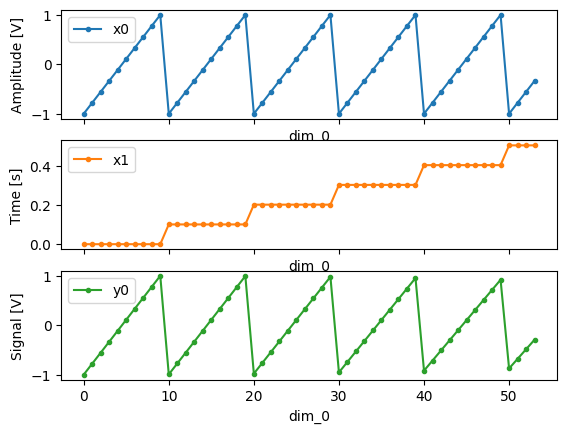

In [8]:
# plot the columns of the dataset
_, axs = plt.subplots(3, 1, sharex=True)
xr.plot.line(quantify_dataset.x0[:54], label="x0", ax=axs[0], marker=".")
xr.plot.line(quantify_dataset.x1[:54], label="x1", ax=axs[1], color="C1", marker=".")
xr.plot.line(quantify_dataset.y0[:54], label="y0", ax=axs[2], color="C2", marker=".")
tuple(ax.legend() for ax in axs)
# return the dataset
quantify_dataset

### Associating dimensions to coordinates

To support both gridded and non-gridded data, we use {doc}`Xarray <xarray:index>`
using only `Data Variables` and `Coordinates` **with a single** `Dimension`
(corresponding to the order of the setpoints).

This is necessary as in the non-gridded case the dataset will be a perfect sparse array, the usability of which is cumbersome.
A prominent example of non-gridded use-cases can be found {ref}`adaptive-tutorial`.

To allow for some of Xarray's more advanced functionality,
such as the in-built graphing or query system we provide a dataset conversion utility
{func}`~quantify_core.data.handling.to_gridded_dataset`.
This function reshapes the data and associates dimensions to the dataset
\[which can also be used for 1D datasets\].

<xarray.Dataset> Size: 9kB
Dimensions:  (x0: 10, x1: 100)
Coordinates:
  * x0       (x0) float64 80B -1.0 -0.7778 -0.5556 -0.3333 ... 0.5556 0.7778 1.0
  * x1       (x1) float64 800B 0.0 0.101 0.202 0.303 ... 9.697 9.798 9.899 10.0
Data variables:
    y0       (x0, x1) float64 8kB -1.0 -0.9949 -0.9797 ... -0.8897 -0.8391
Attributes:
    tuid:                      20240913-214326-973-e14695
    name:                      my experiment
    grid_2d:                   False
    grid_2d_uniformly_spaced:  True
    xlen:                      10
    ylen:                      100

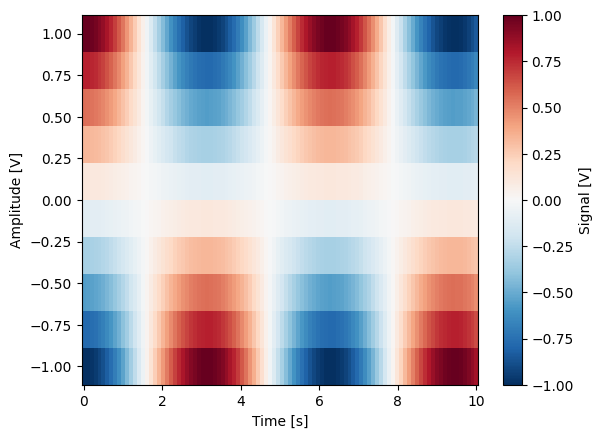

In [9]:
gridded_dset = dh.to_gridded_dataset(quantify_dataset)
gridded_dset.y0.plot()
gridded_dset

## Snapshot

The configuration for each QCoDeS {class}`~qcodes.instrument.Instrument`
used in this experiment.
This information is automatically collected for all Instruments in use.
It is useful for quickly reconstructing a complex set-up or verifying that
{class}`~qcodes.parameters.Parameter` objects are as expected.

(analysis-usage)=

# Analysis

To aid with data analysis, quantify comes with an {mod}`~quantify_core.analysis` module
containing a base data-analysis class
({class}`~quantify_core.analysis.base_analysis.BaseAnalysis`)
that is intended to serve as a template for analysis scripts
and several standard analyses such as
the {class}`~quantify_core.analysis.base_analysis.BasicAnalysis`,
the {class}`~quantify_core.analysis.base_analysis.Basic2DAnalysis`
and the {class}`~quantify_core.analysis.spectroscopy_analysis.ResonatorSpectroscopyAnalysis`.

The idea behind the analysis class is that most analyses follow a common structure
consisting of steps such as data extraction, data processing, fitting to some model,
creating figures, and saving the analysis results.

To showcase the analysis usage we generate a dataset that we would like to analyze.

In [10]:
display_source_code(mk_cosine_instrument)

def mk_cosine_instrument() -> Instrument:
    """A container of parameters (mock instrument) providing a cosine model."""

    instr = Instrument("ParameterHolder")

    # ManualParameter's is a handy class that preserves the QCoDeS' Parameter
    # structure without necessarily having a connection to the physical world
    instr.add_parameter(
        "amp",
        initial_value=0.5,
        unit="V",
        label="Amplitude",
        parameter_class=ManualParameter,
    )
    instr.add_parameter(
        "freq",
        initial_value=1,
        unit="Hz",
        label="Frequency",
        parameter_class=ManualParameter,
    )
    instr.add_parameter(
        "t", initial_value=1, unit="s", label="Time", parameter_class=ManualParameter
    )
    instr.add_parameter(
        "phi",
        initial_value=0,
        unit="Rad",
        label="Phase",
        parameter_class=ManualParameter,
    )
    instr.add_parameter(
        "noise_level",
        initial_value=0.05,
        unit="V",
        label="Noise level",
        parameter_class=ManualParameter,
    )
    instr.add_parameter(
        "acq_delay", initial_value=0.02, unit="s", parameter_class=ManualParameter
    )

    def cosine_model():
        sleep(instr.acq_delay())  # simulates the acquisition delay of an instrument
        return (
            cos_func(instr.t(), instr.freq(), instr.amp(), phase=instr.phi(), offset=0)
            + np.random.randn() * instr.noise_level()
        )

    # Wrap our function in a Parameter to be able to associate metadata to it, e.g. unit
    instr.add_parameter(
        name="sig", label="Signal level", unit="V", get_cmd=cosine_model
    )

    return instr

In [11]:
pars = mk_cosine_instrument()
meas_ctrl.settables(pars.t)
meas_ctrl.setpoints(np.linspace(0, 2, 50))
meas_ctrl.gettables(pars.sig)
dataset = meas_ctrl.run("Cosine experiment")
dataset

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

<xarray.Dataset> Size: 800B
Dimensions:  (dim_0: 50)
Coordinates:
    x0       (dim_0) float64 400B 0.0 0.04082 0.08163 0.1224 ... 1.918 1.959 2.0
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 400B 0.4891 0.4952 0.3783 ... 0.4242 0.5067 0.4974
Attributes:
    tuid:                             20240913-214330-906-ec4c52
    name:                             Cosine experiment
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

## Using an analysis class

Running an analysis is very simple:

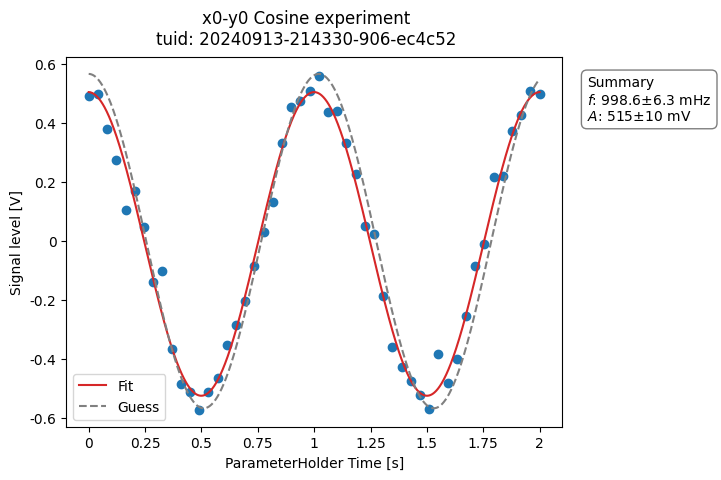

In [12]:
a_obj = ca.CosineAnalysis(label="Cosine experiment")
a_obj.run()  # execute the analysis.
a_obj.display_figs_mpl()  # displays the figures created in previous step.

The analysis was executed against the last dataset that has the label
`"Cosine experiment"` in the filename.

After the analysis the experiment container will look similar to the following:

```{code-block}
20230125-172804-537-f4f73e-Cosine experiment/
├── analysis_CosineAnalysis/
│   ├── dataset_processed.hdf5
│   ├── figs_mpl/
│   │   ├── cos_fit.png
│   │   └── cos_fit.svg
│   ├── fit_results/
│   │   └── cosine.txt
│   └── quantities_of_interest.json
├── dataset.hdf5
└── snapshot.json
```

The analysis object contains several useful methods and attributes such as the
{code}`quantities_of_interest`, intended to store relevant quantities extracted
during analysis, and the processed dataset.
For example, the fitted frequency and amplitude are saved as:

In [13]:
freq = a_obj.quantities_of_interest["frequency"]
amp = a_obj.quantities_of_interest["amplitude"]
print(f"frequency {freq}")
print(f"amplitude {amp}")

frequency 0.999+/-0.006
amplitude 0.515+/-0.010


The use of these methods and attributes is described in more detail in
{ref}`analysis-framework-tutorial`.

## Creating a custom analysis class

The analysis steps and their order of execution are determined by the
{attr}`~quantify_core.analysis.base_analysis.BaseAnalysis.analysis_steps` attribute
as an {class}`~enum.Enum` ({class}`~quantify_core.analysis.base_analysis.AnalysisSteps`).
The corresponding steps are implemented as methods of the analysis class.
An analysis class inheriting from the abstract-base-class
({class}`~quantify_core.analysis.base_analysis.BaseAnalysis`)
will only have to implement those methods that are unique to the custom analysis.
Additionally, if required, a customized analysis flow can be specified by assigning it
to the {attr}`~quantify_core.analysis.base_analysis.BaseAnalysis.analysis_steps` attribute.

The simplest example of an analysis class is the
{class}`~quantify_core.analysis.base_analysis.BasicAnalysis`
that only implements the
{meth}`~quantify_core.analysis.base_analysis.BasicAnalysis.create_figures` method
and relies on the base class for data extraction and saving of the figures.

Take a look at the source code (also available in the API reference):

In [14]:
display_source_code(ba.BasicAnalysis)

class BasicAnalysis(BaseAnalysis):
    """
    A basic analysis that extracts the data from the latest file matching the label
    and plots and stores the data in the experiment container.
    """

    def create_figures(self):
        """
        Creates a line plot x vs y for every data variable yi and coordinate xi in the
        dataset.
        """
        # NB we do not use `to_gridded_dataset` because that can potentially drop
        # repeated measurement of the same x0_i setpoint (e.g., AllXY experiment)
        dataset = self.dataset
        # for compatibility with older datasets
        # in case "x0" is not a coordinate we use "dim_0"
        coords = list(dataset.coords)
        dims = list(dataset.dims)
        plot_against = coords if coords else (dims if dims else [None])
        for idx, xi in enumerate(plot_against):
            for yi, yvals in dataset.data_vars.items():
                # for compatibility with older datasets, do not plot "x0" vs "x0"
                if yi.startswith("y"):
                    fig, ax = plt.subplots()

                    fig_id = f"Line plot x{idx}-{yi}"

                    yvals.plot.line(ax=ax, x=xi, marker=".")

                    adjust_axeslabels_SI(ax)

                    qpl.set_suptitle_from_dataset(fig, self.dataset, f"x{idx}-{yi}")

                    # add the figure and axis to the dicts for saving
                    self.figs_mpl[fig_id] = fig
                    self.axs_mpl[fig_id] = ax

A slightly more complex use case is the
{class}`~quantify_core.analysis.spectroscopy_analysis.ResonatorSpectroscopyAnalysis`
that implements
{meth}`~quantify_core.analysis.spectroscopy_analysis.ResonatorSpectroscopyAnalysis.process_data`
to cast the data to a complex-valued array,
{meth}`~quantify_core.analysis.spectroscopy_analysis.ResonatorSpectroscopyAnalysis.run_fitting`
where a fit is performed using a model
(from the {mod}`quantify_core.analysis.fitting_models` library), and
{meth}`~quantify_core.analysis.spectroscopy_analysis.ResonatorSpectroscopyAnalysis.create_figures`
where the data and the fitted curve are plotted together.

Creating a custom analysis for a particular type of dataset is showcased in the
{ref}`analysis-framework-tutorial`.
There you will also learn some other capabilities of the analysis and practical
productivity tips.

```{seealso}
{ref}`Analysis API documentation <analysis-api>` and
{ref}`tutorial on building custom analyses <analysis-framework-tutorial>`.
```

# Examples: Settables and Gettables

Below we give several examples of experiments that use Settables and Gettables in different control modes.

## Iterative control mode

### Single-float-valued settable(s) and gettable(s)

- Each settable accepts a single float value.
- Gettables return a single float value.

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

<xarray.Dataset> Size: 320B
Dimensions:  (x0: 20)
Coordinates:
  * x0       (x0) float64 160B 0.0 0.3684 0.7368 1.105 ... 5.895 6.263 6.632 7.0
Data variables:
    y0       (x0) float64 160B 1.0 0.9329 0.7406 0.4489 ... 0.9998 0.9399 0.7539
Attributes:
    tuid:                             20240913-214334-531-bc9f04
    name:                             my experiment
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

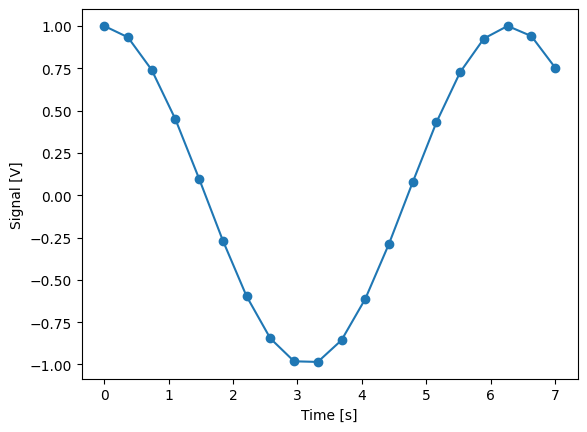

In [15]:
time = ManualParameter(
    name="time", label="Time", unit="s", vals=validators.Numbers(), initial_value=1
)
signal = Parameter(
    name="sig_a", label="Signal", unit="V", get_cmd=lambda: np.cos(time())
)

meas_ctrl.settables(time)
meas_ctrl.gettables(signal)
meas_ctrl.setpoints(np.linspace(0, 7, 20))
dset = meas_ctrl.run("my experiment")
dset_grid = dh.to_gridded_dataset(dset)

dset_grid.y0.plot(marker="o")
dset_grid

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

<xarray.Dataset> Size: 1kB
Dimensions:  (x0: 10, x1: 12)
Coordinates:
  * x0       (x0) float64 80B 0.0 0.5556 1.111 1.667 ... 3.333 3.889 4.444 5.0
  * x1       (x1) float64 96B 0.0 0.4545 0.9091 1.364 ... 3.636 4.091 4.545 5.0
Data variables:
    y0       (x0, x1) float64 960B 1.5 1.788 2.241 2.955 ... 178.3 195.5 222.6
Attributes:
    tuid:                             20240913-214335-097-c74cf9
    name:                             my experiment
    grid_2d:                          False
    grid_2d_uniformly_spaced:         True
    1d_2_settables_uniformly_spaced:  False
    xlen:                             10
    ylen:                             12

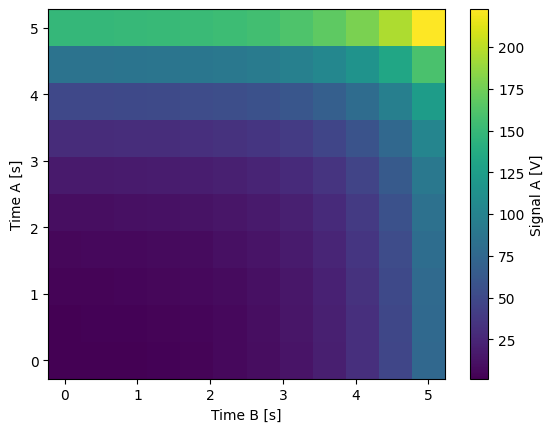

In [16]:
time_a = ManualParameter(
    name="time_a", label="Time A", unit="s", vals=validators.Numbers(), initial_value=1
)
time_b = ManualParameter(
    name="time_b", label="Time B", unit="s", vals=validators.Numbers(), initial_value=1
)
signal = Parameter(
    name="sig_a",
    label="Signal A",
    unit="V",
    get_cmd=lambda: np.exp(time_a()) + 0.5 * np.exp(time_b()),
)

meas_ctrl.settables([time_a, time_b])
meas_ctrl.gettables(signal)
meas_ctrl.setpoints_grid([np.linspace(0, 5, 10), np.linspace(5, 0, 12)])
dset = meas_ctrl.run("my experiment")
dset_grid = dh.to_gridded_dataset(dset)

dset_grid.y0.plot(cmap="viridis")
dset_grid

For more dimensions, you only need to pass more settables and the corresponding setpoints.

Running adaptively...
.

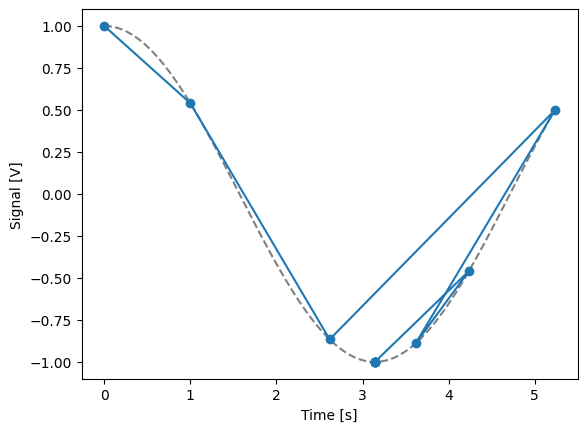

In [17]:
time = ManualParameter(
    name="time", label="Time", unit="s", vals=validators.Numbers(), initial_value=1
)
signal = Parameter(
    name="sig_a", label="Signal", unit="V", get_cmd=lambda: np.cos(time())
)
meas_ctrl.settables(time)
meas_ctrl.gettables(signal)
dset = meas_ctrl.run_adaptive("1D minimizer", {"adaptive_function": minimize_scalar})

dset_ad = dh.to_gridded_dataset(dset)
# add a grey cosine for reference
x = np.linspace(np.min(dset_ad["x0"].values), np.max(dset_ad["x0"].values), 101)
y = np.cos(x)
plt.plot(x, y, c="grey", ls="--")
_ = dset_ad.y0.plot(marker="o")

### Single-float-valued settable(s) with multiple float-valued gettable(s)

- Each settable accepts a single float value.
- Gettables return a 1D array of floats, with each element corresponding to a *different Y dimension*.

We exemplify a 2D case, however, there is no limitation on the number of settables.

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

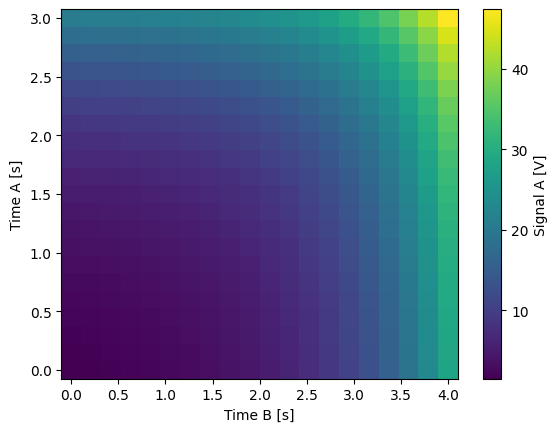

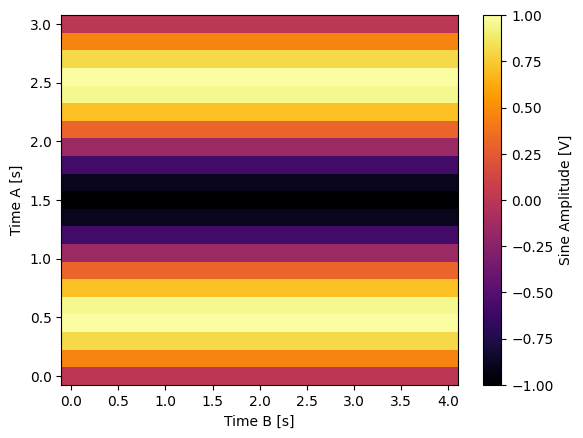

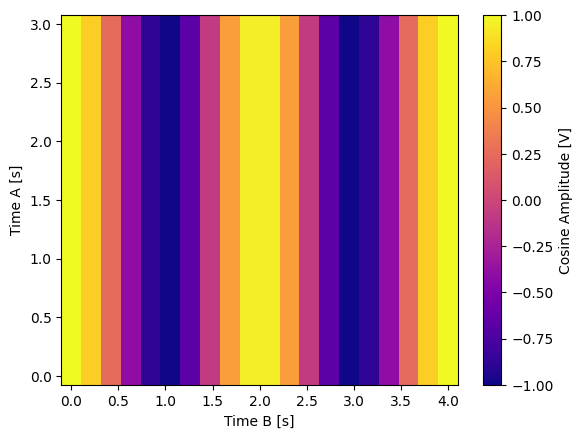

<xarray.Dataset> Size: 10kB
Dimensions:  (x0: 21, x1: 20)
Coordinates:
  * x0       (x0) float64 168B 0.0 0.15 0.3 0.45 0.6 ... 2.4 2.55 2.7 2.85 3.0
  * x1       (x1) float64 160B 0.0 0.2105 0.4211 0.6316 ... 3.579 3.789 4.0
Data variables:
    y0       (x0, x1) float64 3kB 1.5 1.617 1.762 1.94 ... 34.6 38.0 42.2 47.38
    y1       (x0, x1) float64 3kB 0.0 0.0 0.0 ... 3.674e-16 3.674e-16 3.674e-16
    y2       (x0, x1) float64 3kB 1.0 0.7891 0.2455 ... 0.2455 0.7891 1.0
Attributes:
    tuid:                             20240913-214336-174-e41bb1
    name:                             my experiment
    grid_2d:                          False
    grid_2d_uniformly_spaced:         True
    1d_2_settables_uniformly_spaced:  True
    xlen:                             21
    ylen:                             20

In [18]:
time_a = ManualParameter(
    name="time_a", label="Time A", unit="s", vals=validators.Numbers(), initial_value=1
)
time_b = ManualParameter(
    name="time_b", label="Time B", unit="s", vals=validators.Numbers(), initial_value=1
)

signal = Parameter(
    name="sig_a",
    label="Signal A",
    unit="V",
    get_cmd=lambda: np.exp(time_a()) + 0.5 * np.exp(time_b()),
)


class DualWave2D:
    """A "dual" gettable example that depends on two settables."""

    def __init__(self):
        self.unit = ["V", "V"]
        self.label = ["Sine Amplitude", "Cosine Amplitude"]
        self.name = ["sin", "cos"]

    def get(self):
        """Returns the value of the gettable."""
        return np.array([np.sin(time_a() * np.pi), np.cos(time_b() * np.pi)])


dual_wave = DualWave2D()
meas_ctrl.settables([time_a, time_b])
meas_ctrl.gettables([signal, dual_wave])
meas_ctrl.setpoints_grid([np.linspace(0, 3, 21), np.linspace(4, 0, 20)])
dset = meas_ctrl.run("my experiment")
dset_grid = dh.to_gridded_dataset(dset)

for yi, cmap in zip(("y0", "y1", "y2"), ("viridis", "inferno", "plasma")):
    dset_grid[yi].plot(cmap=cmap)
    plt.show()
dset_grid

## Batched control mode

### Float-valued array settable(s) and gettable(s)

- Each settable accepts a 1D array of float values corresponding to all setpoints for a single *X dimension*.
- Gettables return a 1D array of float values with each element corresponding to a datapoint *in a single Y dimension*.

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 time 
Batch size limit: 20



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it


NOTE: The gettable returns an array:

[ 1.          0.93289715  0.7405942   0.4488993   0.09695955 -0.26799272
 -0.59697884 -0.84584701 -0.98119769 -0.98486606 -0.8563598  -0.61292518
 -0.28723252  0.07700839  0.43091433  0.72698911  0.92549782  0.99979946
  0.93992232  0.75390225]


<xarray.Dataset> Size: 320B
Dimensions:  (x0: 20)
Coordinates:
  * x0       (x0) float64 160B 0.0 0.3684 0.7368 1.105 ... 5.895 6.263 6.632 7.0
Data variables:
    y0       (x0) float64 160B 1.0 0.9329 0.7406 0.4489 ... 0.9998 0.9399 0.7539
Attributes:
    tuid:                             20240913-214337-678-7b2204
    name:                             my experiment
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

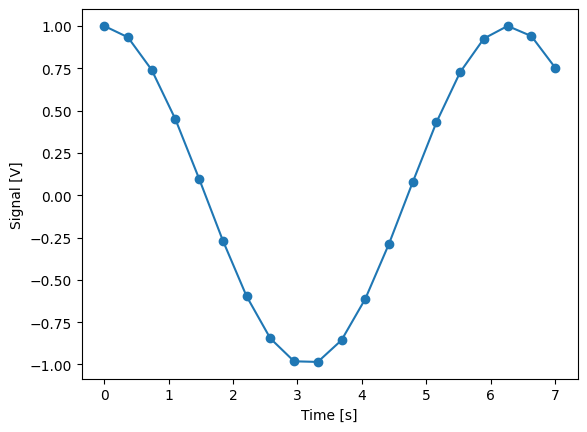

In [19]:
time = ManualParameter(
    name="time",
    label="Time",
    unit="s",
    vals=validators.Arrays(),
    initial_value=np.array([1, 2, 3]),
)
signal = Parameter(
    name="sig_a", label="Signal", unit="V", get_cmd=lambda: np.cos(time())
)

time.batched = True
signal.batched = True

meas_ctrl.settables(time)
meas_ctrl.gettables(signal)
meas_ctrl.setpoints(np.linspace(0, 7, 20))
dset = meas_ctrl.run("my experiment")
dset_grid = dh.to_gridded_dataset(dset)

dset_grid.y0.plot(marker="o")
print(f"\nNOTE: The gettable returns an array:\n\n{signal.get()}")
dset_grid

### Mixing iterative and batched settables

In this case:

- One or more settables accept a 1D array of float values corresponding to all setpoints for the corresponding *X dimension*.
- One or more settables accept a float value corresponding to its *X dimension*.

Measurement control will set the value of each of these iterative settables before each batch.

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 time_a 
Batched settable(s):
	 time_b 
Batch size limit: 12



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

<xarray.Dataset> Size: 1kB
Dimensions:  (x0: 10, x1: 12)
Coordinates:
  * x0       (x0) float64 80B 0.0 0.5556 1.111 1.667 ... 3.333 3.889 4.444 5.0
  * x1       (x1) float64 96B 0.0 0.3636 0.7273 1.091 ... 2.909 3.273 3.636 4.0
Data variables:
    y0       (x0, x1) float64 960B 1.5 1.719 2.035 2.488 ... 161.6 167.4 175.7
Attributes:
    tuid:                             20240913-214338-127-16a9bd
    name:                             my experiment
    grid_2d:                          False
    grid_2d_uniformly_spaced:         True
    1d_2_settables_uniformly_spaced:  False
    xlen:                             10
    ylen:                             12

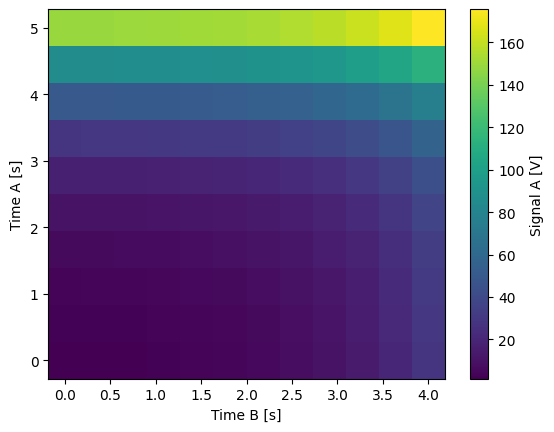

In [20]:
time_a = ManualParameter(
    name="time_a", label="Time A", unit="s", vals=validators.Numbers(), initial_value=1
)
time_b = ManualParameter(
    name="time_b",
    label="Time B",
    unit="s",
    vals=validators.Arrays(),
    initial_value=np.array([1, 2, 3]),
)
signal = Parameter(
    name="sig_a",
    label="Signal A",
    unit="V",
    get_cmd=lambda: np.exp(time_a()) + 0.5 * np.exp(time_b()),
)

time_b.batched = True
time_b.batch_size = 12
signal.batched = True

meas_ctrl.settables([time_a, time_b])
meas_ctrl.gettables(signal)
# `setpoints_grid` will take into account the `.batched` attribute
meas_ctrl.setpoints_grid([np.linspace(0, 5, 10), np.linspace(4, 0, time_b.batch_size)])
dset = meas_ctrl.run("my experiment")
dset_grid = dh.to_gridded_dataset(dset)

dset_grid.y0.plot(cmap="viridis")
dset_grid

### Float-valued array settable(s) with multi-return float-valued array gettable(s)

- Each settable accepts a 1D array of float values corresponding to all setpoints
  for a single *X dimension*.
- Gettables return a 2D array of float values with each row representing a
  *different Y dimension*, i.e. each column is a datapoint corresponding
  to each setpoint.

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 time 
Batch size limit: 100



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

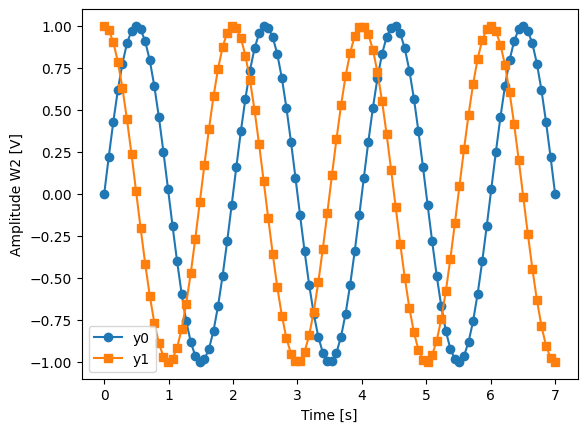

In [21]:
time = ManualParameter(
    name="time",
    label="Time",
    unit="s",
    vals=validators.Arrays(),
    initial_value=np.array([1, 2, 3]),
)


class DualWaveBatched:
    """A "dual" batched gettable example."""

    def __init__(self):
        self.unit = ["V", "V"]
        self.label = ["Amplitude W1", "Amplitude W2"]
        self.name = ["sine", "cosine"]
        self.batched = True
        self.batch_size = 100

    def get(self):
        """Returns the value of the gettable."""
        return np.array([np.sin(time() * np.pi), np.cos(time() * np.pi)])


time.batched = True
dual_wave = DualWaveBatched()

meas_ctrl.settables(time)
meas_ctrl.gettables(dual_wave)
meas_ctrl.setpoints(np.linspace(0, 7, 100))
dset = meas_ctrl.run("my experiment")
dset_grid = dh.to_gridded_dataset(dset)

_, ax = plt.subplots()
dset_grid.y0.plot(marker="o", label="y0", ax=ax)
dset_grid.y1.plot(marker="s", label="y1", ax=ax)
_ = ax.legend()